<a href="https://colab.research.google.com/github/Jihyun0510/nlp_hw/blob/main/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

<!-- In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). This model achives our best perplexity yet, ~27 compared to ~34 for the previous model. -->

## Introduction

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

위 figure와 같이 기본 encoder과 encoder는 context vector $z$에 source setence의 모든 정보를 압축하여 decoder애 전달하고 decoder는 이를 입력 받아 time step마다 hidden state $s_t$와 embeeded 입력 단어 $d(y_t)$와 함께께 사용하여 예측을 하였다. 이러한 방식은 source sentece의 크기가 커질 경우에도 많은 정보를 고정된 크기의 vector에 담아야한다는 한계가 있다. 

이를 개선하기 위해서 Neural Machine Translation by Jointly Learning to Align and Translate에서는 attention 개념을 도입한다. 이를 통해서 decoder에서 고정된 vector을 사용해  source setence의 정보를 얻는 것이 아니라 각 예측 단계마다 weighted source vector $w$을 계산하여 source sentence의 정보를 얻는다. $w$를 계산하기 위해서 우선 (source setence와 동일한 크기의) attention vector $a$을 계산하고 이를 사용하여 source setence hidden states $H$의 weighted source vector $w$을 계산한다. 


$$w = \sum_{i}a_ih_i$$

따라서 입력 시퀀스를 벡터 시퀀스로 인코딩한 후, 매 디코딩 step마다 벡터 시퀀스의 subset을 adaptive하게 선택한다. (=Handle this issue by allowing a model to automatically search for parts of a source)

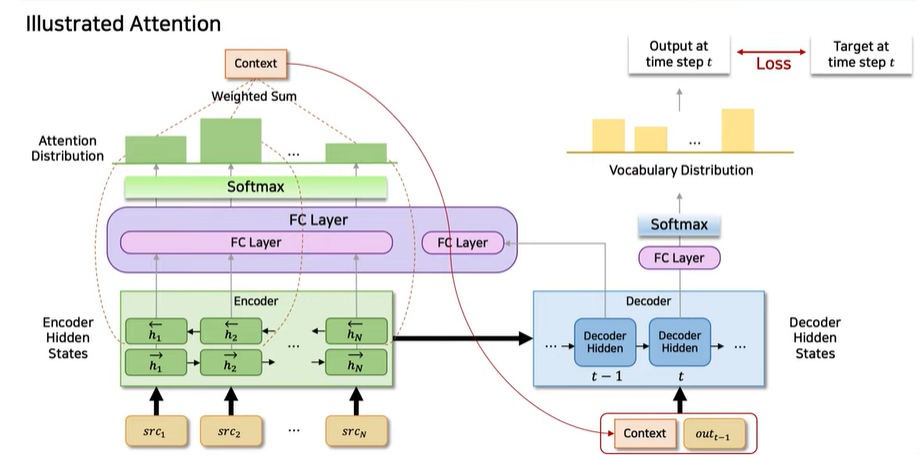

## Preparing data

In [1]:
# 구버전 파이토치 패키지 설치
# !pip install torch==1.8.0 torchtext==0.9.0
# !pip install torch==1.7.1 torchtext==0.8.1
!pip install torchtext==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.9/881.9 MB 1.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.10.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.10.0 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, bu

In [2]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

Random seed를 고정하여 라이브러리들의 가중치 초기값이나 train/test set을 동일하게 split하는 등 작동 결과를 고정한다. 이를 통해서 실행 때마다 동일한 결과를 재현할 수 있다.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Tockenization 작업을 진행하기 위해 사용할 spaCy를 다운로드 한다. Tockenization은 말뭉치 corpus를 토큰(token)이라 불리는 단위로 나누는 작업이다. 토큰의 단위가 상황에 따라 다르며, 보통 word 등 의미있는 단위로 토큰을 정의한다.

In [5]:
# spacy와 colab의 충돌로 인한 locale encoding 문제 해결
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

#영어, 독일어 spacy 모델을 다운로드
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

2023-04-12 01:46:42.653934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-04-12 01:46:58.919836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 39.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [6]:
# 모델 불러오기
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

spaCy의 기능 중 하나인 tocknizer을 각각 영어와 독일어에 대해서 만든다.

In [7]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

자연어 처리 라이브러리 토치텍스트(Torchtext)의 기능중 하나인 Field를 사용하여 필드를 통해 앞으로 어떤 전처리를 할 것인지를 정의한다. 

* tocknise = 어떤 토큰화 함수를 사용할 것인지 지정. (string.split이 기본값)
* lower = 영어 데이터를 전부 소문자화한다. (False가 기본값)
* batch_first = 미니 배치 차원을 맨 앞으로 하여 데이터를 불러올 것인지 여부. (False가 기본값)


In [8]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Multi30k dataset을 로드하고 train, validation, test dataset으로  split한다.
또한 필드를 지정해줌으로써 미리 정의해 두었던 설정대로 데이터셋을 전처리 한다.


In [9]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


100%|██████████| 1.21M/1.21M [00:01<00:00, 660kB/s] 


downloading validation.tar.gz


100%|██████████| 46.3k/46.3k [00:00<00:00, 178kB/s]


downloading mmt_task1_test2016.tar.gz


100%|██████████| 66.2k/66.2k [00:00<00:00, 169kB/s]


In [10]:
# 크기 확인
print('train 데이터의 크기 : {}' .format(len(train_data)))
print('test 데이터의 크기 : {}' .format(len(test_data)))

train 데이터의 크기 : 29000
test 데이터의 크기 : 1000


In [11]:
# train data 예시 확인
print("Source sentence:", vars(train_data[0])["src"])
print("Target sentence:", vars(train_data[0])["trg"])

Source sentence: ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
Target sentence: ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


토큰화가 끝나고 단어 집합을 만들어주어야 한다. 정의한 필드에 .build_vocab()을 사용하여 단어 집합을 생성한다. Vocabulary는 각각의 unique token에 고유한 정수 인덱스가 맵핑된 토큰의 집합이다.
모델을 학습시킬 때 단어(문자열/토큰) 대신 정수 인덱스가 사용되게 된다.


min_freq은 token이 vocabulary에 포함되기 위해 최소한으로 등장해야하는 횟수이다.  min_freq번 미만 사용된 단어는 vocabulary에 포함되지 않고 unknown 토큰으로 대체된다.

In [12]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [13]:
# vocab 확인, 사전형식으로 되어 있음을 확인할 수 있음
print(SRC.vocab.stoi)
# vocab의 크기 확인
print(len(SRC.vocab.stoi))

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7fe2683c7c40>>, {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, '.': 4, 'ein': 5, 'einem': 6, 'in': 7, 'eine': 8, ',': 9, 'und': 10, 'mit': 11, 'auf': 12, 'mann': 13, 'einer': 14, 'der': 15, 'frau': 16, 'die': 17, 'zwei': 18, 'einen': 19, 'im': 20, 'an': 21, 'von': 22, 'sich': 23, 'dem': 24, 'mädchen': 25, 'junge': 26, 'vor': 27, 'zu': 28, 'steht': 29, 'männer': 30, 'sitzt': 31, 'hund': 32, 'den': 33, 'straße': 34, 'während': 35, 'gruppe': 36, 'hält': 37, 'spielt': 38, 'das': 39, 'hemd': 40, 'personen': 41, 'über': 42, 'drei': 43, 'eines': 44, 'frauen': 45, 'blauen': 46, 'neben': 47, 'ist': 48, 'kind': 49, 'roten': 50, 'weißen': 51, 'stehen': 52, 'sitzen': 53, 'menschen': 54, 'am': 55, 'aus': 56, 'spielen': 57, 'durch': 58, 'bei': 59, 'geht': 60, 'trägt': 61, 'fährt': 62, 'wasser': 63, 'um': 64, 'kinder': 65, 'kleines': 66, 'person': 67, 'macht': 68, 'springt': 69, 'kleiner': 70, 'schwarzen

Define the device.

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create the iterators.

Batch size를 128로 설정함으로써 한 iteration마다 128개의 입력 문장이 처리되도록 한다.

In [15]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

## Building the Seq2Seq Model

### Encoder


<!-- 
We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder. -->

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq8.png?raw=1)

해당 논문에서는 encoder로 bidrectional한 재귀모델을 사용한다. 해당 implementation에서는 bidrectional GRU를 사용한다. GRU는 RNN의 일종으로 LSTM의 구조를 단순화해 학습 속도를 높인 재귀모델이다. Bidirectional한 재귀모델을 사용하는 이유는 시간적으로 앞의 데이터만 가지고는 올바른 예측을 할수 없기 때문이다. 이전에 나타난 것만이 아니라, 미래에 나타난 데이터가 t 시점의 단어에 영향을 주기도 때문이다. Bidirectional 모델은 이러한 것을 해결하기 위하여, 정방향뿐 아닌 역방향의 전파까지도 실행한다. Bidrectional GRU를 사용하기 위해서 bidirectional 인자를 True로 설정하면 된다. 

Bidirectional enoder는 forward encoder와 backward encoder로 구성되어 있다. Time t의 토큰을 입력하면 forward encoder는 t-1의 hidden state와 embedding된 입력 토큰으로 $h_T^\rightarrow$를 생성한다. 반대로 backward encoder는 hidden state at time t+1과 embedding된 input token at time t으로$h_T^\leftarrow$를 생성한다.  

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

더불어, $x_0^\rightarrow = \text{<sos>}$이며 $x_0^\leftarrow = \text{<eos>}$이다.

토큰 x를 입력 받으면 RNN은 outputs와 hidden을 return하게 되는데 outputs는 **[src len, batch size, hid dim * num directions]** 의 크기를 가진다. Outputs의 hid dim의 first axis는 backward RNN의 top layer의 hidden states이며 second axis는 forward RNN의 top layer의 hidden states이며 third axis는 앞 두 hidden states를 합친 것이다. i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$. eoncder의 모든 hidden states는 다음과 같이 표현할 수 있다. $H=\{ h_1, h_2, ..., h_T\}$.

hidden은  **[n layers * num directions, batch size, hid dim]**의 크기를 가지며, n layer의 마지막은 forward rnn의 final time-step 뒤의 hidden stated의 top layer이며 n layer의 2번쨰 layer는 final time step (after it has seen the first word) 뒤의 backward RNN hidden state의 top layer이다. 이는 context vector에 해당하며 decoder의 initial hidden state으로 사용된다. 논문에서는 backward RNN의 context vector만 사용하지만 해당 implementation에서는 두 context vector 모두 사용한다. $$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$.

정리하자면, encoder는 time step t마다 hidden과 outputs를 return하고 hidden은 각 time step마다 누적된 hidden states이고 outputs는 context vector이다.




In [32]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        '''
        encoder는 input_dim 가지의 emb_dim 차원의 임베딩 벡터를 출력함
        input_dim은 source 언어의 vacabulary 크기와 동일함'''
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        '''bidirectional 인자를 True로 설정함으로써 bidrectional GRU를 사용'''
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        '''
        fully connected layer의 입력 hidden dimension은 RNN이 2개이기 때문에 2를 곱함 
        encoder의 마지막 hidden state는 decoder의 initial hidden dimension으로 사용되기 때문에 2를 곱하지 않음 
        두 hidden dimension의 차원을 맞추기 위하여 해당 fully connected layer을 사용함'''
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        '''embedding layer을 사용하여  source senttence token을 embedding하고 dropout을 적용함
        주의할 점은 batch size가 2번째 axis로 설정되어 있음 '''
        #src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))
        ''' embedding된 source setence tokens은 아래와 같은 크기를 가짐 '''
        #embedded = [src len, batch size, emb dim]
        
        ''' bidirectional RNN layers를 통과시켜 outputs와 hidden을 return 받음'''
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        '''
        ecoder의 initial hidden은 forward와 backward RNN의 마지막 hidden states이다.
        따라서 batch size 차원을 축으로 두 context vectors를 합친다. 
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        '''
        # concatenate 과정을 알기 위한 코드드
        # print("!!!!!!!!!!!!!!!!!!!!!!last of the forwards RNN hidden states size: {}".format(hidden[-2,:,:].shape)) # torch.Size([128, 512])
        # print("!!!!!!!!!!!!!!!!!!!!!!last of the backwards RNN hidden states size: {}".format(hidden[-1,:,:].shape)) # torch.Size([128, 512])
        # print("!!!!!!!!!!!!!!!!!!!!!!concatenated RNN hidden states size: {}".format(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1).shape)) # torch.Size([128, 1024])

         
        '''encoder RNNs fed through a linear layer 이를 통해서 hidden states는 deocoder의 hidden states와 크기가 동일해짐''' 
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2] 
        ''' src len는 곧 time step이기 때문에 각 time step 별 hidden states의 마지막 layer가 반환됨 '''
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

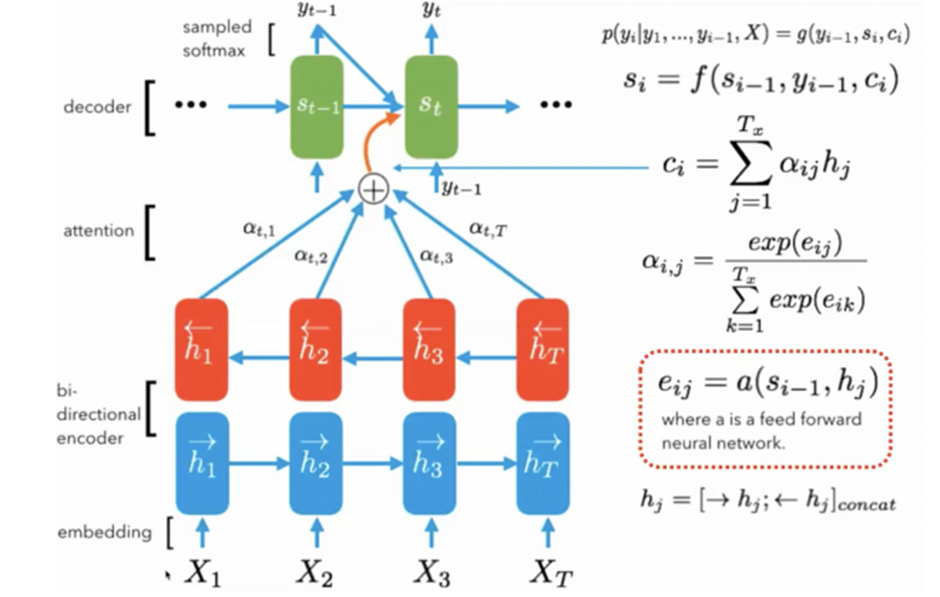

### Attention

Attention layer는 decoder의 time step at t-1 hidden state $s_{t-1}$와 encoder의 누적된 모든 forward, backward hidden states $H$를 입력 받아 attention vector at time t $a_t$를 반환한다.
Attention vector는 source setence와 동일한 길이를 가지며 각 원소는 0과 1사이의 값을 갖는다. 모든 원소의 합은 1이다.

<!-- Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1. -->

직관적으로 attention layer는 decoder에서 막 디코딩한 것과 인코딩한 모든 것을 입력 받아 attention vector을 생성한다. 이때 attention vector는 다음 단어 $\hat{y}_{t+1}$를 예측하기 위해 source setence의 어떤 단어들에 더 주의를 두어야 하는지 나타내는 것으로 이해할 수 있다. 

<!-- Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$.  -->


Attention vector을 구하기 위하여 이전 deocder hidden state와 eoncder hidden states 사이의 energy를 계산한다. 비교하기 위해서 두 hidden states의 차원을 맞추어 준다. Encoder hidden states는 T개 존재하며 decoder hidden state는 single tensor이기 때문에 이를 T만큼 repeat한다. 그 다음 이 둘을 합친 후 attention layer와 $\tanh$ activation function을 통과시켜 energy를 계산한다. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

Energy 값은 각 encoder hidden state가 이전 decoder hidden state에 얼마나 잘 매칭되는지를 나타낸다. 
<!-- First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state. -->

<!-- We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of $v$ as the weights for a weighted sum of the energy across all encoder hidden states. These weights tell us how much we should attend to each token in the source sequence. The parameters of $v$ are initialized randomly, but learned with the rest of the model via backpropagation. Note how $v$ is not dependent on time, and the same $v$ is used for each time-step of the decoding. We implement $v$ as a linear layer without a bias.

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block. -->

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq9.png?raw=1)

In [33]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        '''
        energy 함수의 input으로 encoder의 hidden states와 decoder의 이전 hidden states를 받으니까 
        attention layer의 input으로 (enc_hid_dim * 2) + dec_hid_dim를 설정함
        encoder의 hidden state마다 decoder의 이전 hidden state를 비교하였으므로 decoder의 hidden state가 T sequence만큼 존재함
        '''
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        '''
        v layer을 통해서 T sequence만큼 존재하는 decoder의 hidden state를 합침
        따라서 v는 모든 encoder의 hidden state를 합치는 weights라고 볼 수 있음
        '''
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Decoder

본 implementatioh에서는 decoder에서 attention layer을 포함하고 있다.
<!-- The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$. -->
Attention vector $a_t$을 weight를 사용하여 encoder hidden states의 weighted sum인 $w_t$을 구한다. 
<!-- We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights. -->

$$w_t = a_t H$$

Hidden state at time t를 구하기 위해서는 이전 hidden state, weighted um of the eoncder hidden states at time t, time t에서의 decoder output $d(y_t)을 입력 받는다. 
<!-- The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together. -->

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

그 다음 target word at time t+!을 예측하기 위해서 linear layer, $f$에 $d(y_t)$, $w_t$ , $s_t$을 통과시킨다. 
<!-- We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together. -->

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

<!-- The image below shows decoding the first word in an example translation. -->

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq10.png?raw=1)

<!-- The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$. -->

In [34]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Seq2Seq
<!-- 
This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate -->

In [35]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio 는 teach forcing을 사용할 확률임 
        #e.g. 예를 들어 teach forching ration가 0.75이면 75%의 확률로 teacher forcing을 사용함 
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # decoder outputs를 저장할 tensor 
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs는 intput sequence의 back 그리고 forward의 모든 hidden states임 
        #hidden는 linear layer을 통과한 마지막 forward 그리고 backward hidden states임 
        encoder_outputs, hidden = self.encoder(src)
                
        #decoder의 첫번째 입력은 <sos> 토큰임 
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #입력 토큰 임베딩, 이전 hidden state, encoder의 모든 hidden states가 입력됨 
            #output tensor와 새로운 hidden state을 받음
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            # 각 토큰에 대한 예측을 tensor에 저장함 
            outputs[t] = output
            
            # teacher forching을 사용할 것인지에 대한 여부 
            teacher_force = random.random() < teacher_forcing_ratio
            
            # predictions로부터 가장 높은 값의 predicted tork을 top1에 지정 
            top1 = output.argmax(1) 
            
            # teacher forcing을 사용한다면 실제 다음 토큰을 다음 입력으로 사용 
            # teacher forcing을 사용하지 않는다면 predicted 토큰을 다음 입력으로 사용
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

parameters, encoder, decoder 그리고 seq2seq 모델을 초기화한다. 

In [36]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)


해당 implementation에서는 모든 bias를 0으로 설정하고 ahems weights는 $\mathcal{N}(0, 0.01)$로부터 초기화한다. 

In [37]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


In [39]:
optimizer = optim.Adam(model.parameters())

loss function을 초가화한다.

In [40]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

학습 코드를 생성한다.

In [41]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [42]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [43]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [44]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 31s
	Train Loss: 5.040 | Train PPL: 154.401
	 Val. Loss: 5.008 |  Val. PPL: 149.591
Epoch: 02 | Time: 1m 36s
	Train Loss: 4.145 | Train PPL:  63.145
	 Val. Loss: 4.429 |  Val. PPL:  83.806
Epoch: 03 | Time: 1m 36s
	Train Loss: 3.473 | Train PPL:  32.226
	 Val. Loss: 3.717 |  Val. PPL:  41.140
Epoch: 04 | Time: 1m 34s
	Train Loss: 2.912 | Train PPL:  18.398
	 Val. Loss: 3.495 |  Val. PPL:  32.950
Epoch: 05 | Time: 1m 35s
	Train Loss: 2.512 | Train PPL:  12.333
	 Val. Loss: 3.268 |  Val. PPL:  26.257
Epoch: 06 | Time: 1m 34s
	Train Loss: 2.209 | Train PPL:   9.108
	 Val. Loss: 3.262 |  Val. PPL:  26.101
Epoch: 07 | Time: 1m 34s
	Train Loss: 1.976 | Train PPL:   7.217
	 Val. Loss: 3.209 |  Val. PPL:  24.760
Epoch: 08 | Time: 1m 35s
	Train Loss: 1.758 | Train PPL:   5.798
	 Val. Loss: 3.186 |  Val. PPL:  24.187
Epoch: 09 | Time: 1m 30s
	Train Loss: 1.583 | Train PPL:   4.870
	 Val. Loss: 3.242 |  Val. PPL:  25.581
Epoch: 10 | Time: 1m 30s
	Train Loss: 1.460 | Train PPL

Finally, we test the model on the test set using these "best" parameters.

In [45]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.190 | Test PPL:  24.283 |


In [55]:
with torch.no_grad():

    for i, batch in enumerate(test_iterator):
        '''배치의 첫 데이터만을 사용
            vocabulary에서 token의 index로부터 단어를 찾아 출력'''
        if i == 1:
            break
        src = batch.src
        trg = batch.trg
        src, trg = src[:,0], trg[:,0]
        print("Source sentence")
        for token in src:
            print(SRC.vocab.itos[token])
        print("\nTarget sentence")
        for token in trg:
            print(TRG.vocab.itos[token])

        src, trg = src.reshape(-1, 1), trg.reshape(-1, 1)
        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        output = output.argmax(dim=1)
        print("\nTranslated sentence")
        for token in output:
            print(TRG.vocab.itos[token])

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

Source sentence
<sos>
zwei
mittelgroße
hunde
laufen
über
den
schnee
.
<eos>

Target sentence
<sos>
two
medium
sized
dogs
run
across
the
snow
.
<eos>
<pad>
<pad>
<pad>

Translated sentence
two
medium
-
colored
dogs
running
running
through
the
snow
.
<eos>
snow
